## Imports

In [1]:
#Library imports
import re
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

from IPython.display import Image, display
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2


#User Created functions

from cleaning_functions import *
from eda_functions import *
from modeling_functions import *
from setup_functions import *

from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
#Without this block the Japanese font's won't display properly in Matplotlib.Set to your font directory.
extend_matplotlib_fonts("/usr/share/fonts/")

/home/anacuda/work/nyc-mhtn-ds-021720/japanese_text_classifiers/setup_functions.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [3]:
#Device specific gpu deterministic arguments
from tensorflow import config as tfconfig
physical_devices = tfconfig.list_physical_devices('GPU')
tfconfig.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
#Sets random seeds to allow for reproducable results.
from tensorflow import random as tfrandom
SEED=127
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tfrandom.set_seed(SEED)

In [5]:
train_data = np.load("data/kuzushiji49/train/k49-train-imgs.npz")['arr_0']
train_labels = np.load("data/kuzushiji49/train/k49-train-labels.npz")['arr_0']
test_data = np.load("data/kuzushiji49/test/k49-test-imgs.npz")['arr_0']
test_labels = np.load("data/kuzushiji49/test/k49-test-labels.npz")['arr_0']
classmap = pd.read_csv("data/kuzushiji49/k49_classmap.csv")

## EDA

The data from the kuzushiji dataset in it's initial state is relatively straightforward, there are over 200,000 observations across 49 classes (Some appear to be better represented than others). The image resolution is very small (28x28) and the lack of color channels indicate greyscale images.

In [7]:
train_data.shape

(232365, 28, 28)

In [8]:
full_value_counts(pd.DataFrame(train_labels), 0)

There are 49 unique values with 0 nan values making up 0.0%
6000-24 --2.58%
6000-27 --2.58%
6000-47 --2.58%
6000-21 --2.58%
6000-20 --2.58%
6000-19 --2.58%
6000-18 --2.58%
6000-17 --2.58%
6000-15 --2.58%
6000-12 --2.58%
6000-11 --2.58%
6000-10 --2.58%
6000-9 --2.58%
6000-7 --2.58%
6000-6 --2.58%
6000-5 --2.58%
6000-4 --2.58%
6000-2 --2.58%
6000-1 --2.58%
6000-25 --2.58%
6000-0 --2.58%
6000-28 --2.58%
6000-46 --2.58%
6000-30 --2.58%
6000-41 --2.58%
6000-40 --2.58%
6000-39 --2.58%
6000-38 --2.58%
6000-34 --2.58%
6000-35 --2.58%
6000-37 --2.58%
5132-26 --2.21%
4714-8 --2.03%
4165-13 --1.79%
3867-14 --1.66%
3523-48 --1.52%
3394-33 --1.46%
3060-31 --1.32%
2565-16 --1.10%
2451-23 --1.05%
2397-43 --1.03%
2139-42 --0.92%
2063-22 --0.89%
1993-29 --0.86%
1718-32 --0.74%
1598-36 --0.69%
777-3 --0.33%
417-44 --0.18%
392-45 --0.17%


The small resolution does not impede the distinguishability of these glyphs. Everything appears to use the space as full as possible where the edges are cropped based on the size of the writing.

In [9]:
bulk_character_viewer(data=train_data, labels=map_char_codes(train_labels, classmap), indices=(0,60), columns=15)

The earlier list of classification labels revealed that some characters have much better representation than others in the dataset. It would help to group the data for visualization with a barchart.

In [10]:
counts = pd.Series(train_labels).reset_index().groupby(0).count().reset_index().rename(columns={0:"index", "index":"count"})
counts = counts.merge(classmap, how="left", on="index")

There is a fairly large class imbalance for roughly 1/3 of the values. The two characters with the least observations had actually been officially declared obsolete in the mid 40s so it is reasonable to expect that they would be less common throughout historical literature. The lack of presence of the character え in the dataset of classical texts is a bit harder to explain.

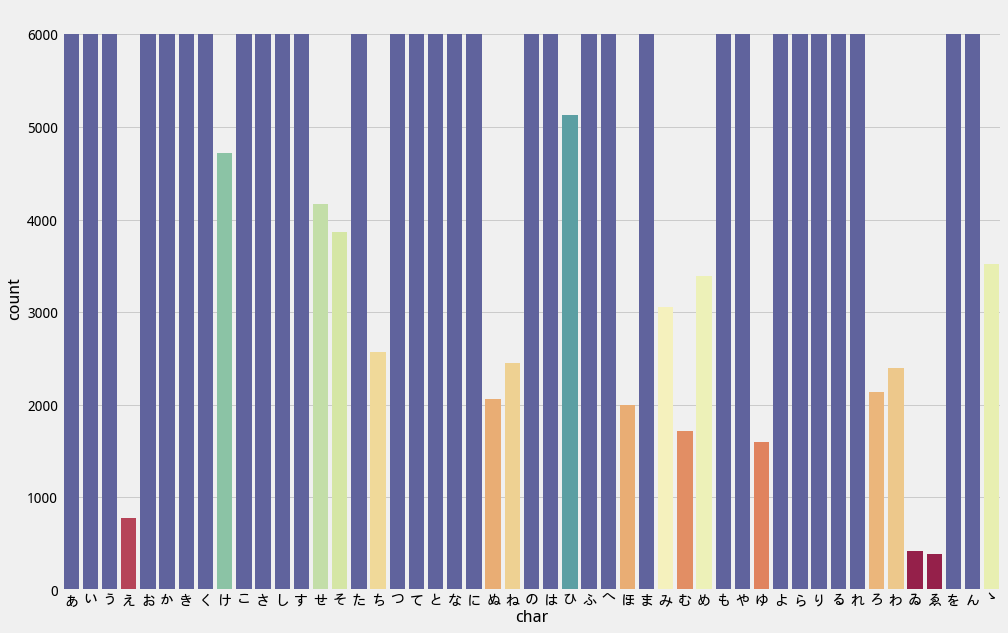

In [11]:
warnings.filterwarnings('ignore')
fig, ax = common_plot_setup(style="fivethirtyeight", font="Droid Sans")
sns.barplot("char", "count", data=counts, ax=ax, palette=colors_from_values(counts["count"], 'Spectral'))
plt.xticks(fontname = "Droid Sans Japanese")
plt.show()
warnings.filterwarnings('default')

## Preprocessing

Since this data will be used to better the predictions of modern glyphs in the hiragana character set, including them does not benefit the model . Not only do the 3 obsolete characters have the two lowest observation counts, but the no longer used iteration mark (ゝ) is easily confused with ku (く) since in the kuzushiji dataset it does not have a consistent orientation across the verticle axis.
<img src = "img/iter-ku/itergrid.png">

To maintain an extra version with these glyphs would add a layer of complexity to the modeling process so they have been removed from current commits.

In [6]:
#This creates a mask to eliminate the hiragana that are out of date
obsolete_mask_train = (train_labels != 44) & (train_labels != 45) & (train_labels != 48)
obsolete_mask_test = (test_labels != 44) & (test_labels != 45) & (test_labels != 48)

#Everything now will need it's own
train_data_cur, train_labels_cur = train_data[obsolete_mask_train], train_labels[obsolete_mask_train]
test_data_cur, test_labels_cur = test_data[obsolete_mask_test], test_labels[obsolete_mask_test]

# It also will help to shift the labels to remove the gaps in the training data, testing data, and the classmap.
train_labels_cur = np.where((train_labels_cur == 46) | (train_labels_cur == 47), train_labels_cur-2, train_labels_cur)
test_labels_cur = np.where((test_labels_cur == 46) | (test_labels_cur == 47), test_labels_cur-2, test_labels_cur)
classmap_cur = classmap.drop([44, 45, 48]).reset_index().drop(columns=["level_0", "index"]).reset_index()

I created several functions to handle the preprocessing that give a reasonable degree of flexibility to handle tweaks that may be necessary during the modeling process. The order of operations is essentially adding padding to the image boundaries, converting the rgb values to normalized floats, splitting the training data into training and validation sets, resampling the training data to account for the class imbalance, and finally expanding the vector labels into a matrix.

In [7]:
def preprocess_raster_common(array, bits=8, x_pad=0, y_pad=0):
    """This function is used to capture the preprocessing steps that can be univerally be applied to all observations before
    the split."""
    
    X = array.copy()
    
    # Adds padding to the edges of the bitmap data (Located in cleaning functions).
    X = pad_raster_edges(X, x_pad, y_pad)
    
    # Scales the values between 0 and 1 (Located in cleaning functions).
    X = color_values_to_float(X, bits)
    
    return images_to_1d(X)

def preprocess_raster_pipeline(array, labels, bits=8, resample=None, random_state=None, test_size=None, x_pad=0, y_pad=0):
    X = preprocess_raster_common(array, bits, x_pad, y_pad)
    y = labels.copy()
    
    # Will perform a train test split if the "test size parameter is specified. Otherwise it uses one set of data."
    if test_size:
        # The data should be split before upsampling to prevent data leakage.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_train, y_train = preprocess_raster_resampling(X_train, y_train, resample, random_state)
        return X_train, X_test, to_categorical(y_train), to_categorical(y_test)
    else:
        X, y = preprocess_raster_resampling(X, y, resample, random_state)
        return X, to_categorical(y)

Through the process, I found that my models had better results when the class imbalance was rectified through the SMOTE algorithm. I also added two pixels of padding on each side for several reasons.
* To preserve data when passed through CNN filters
* The clean boundaries at the edges will also minimize cropping and unwanted artifacts when transformations are applied with the image generator.
* A 32x32 matrix created more options than a 28x28 matrix when transfer learning with pretrained models.

In [8]:
X_train, X_val, y_train, y_val = preprocess_raster_pipeline(train_data_cur, train_labels_cur, resample="smote", test_size=.2,
                                                            random_state = SEED, x_pad=2, y_pad=2)
X_test, y_test = preprocess_raster_pipeline(test_data_cur, test_labels_cur, x_pad=2, y_pad=2)

performing SMOTE
Ignoring class imbalances


The function above transformed each observation into a vector. However I also needed to create a version of the data that restores the missing dimensions for shape compatibility with convolutional network filters and the pretrained models for transfer learning. In the case of transfer learning, I duplicated the channel data twice for compatibility with Keras's selection of pretrained models.

In [9]:
# For the CNN models this function will make a version of the data that reshapes it back from it's vector representation while explicitly including it's one color channel.
X_train_2d = images_to_1d(X_train, 32, 32, 1, inverse=True)
X_val_2d = images_to_1d(X_val, 32, 32, 1, inverse=True)
X_test_2d = images_to_1d(X_test, 32, 32, 1, inverse=True)

# Another version that duplicates the data to two other color channels, for enhanced compatibility for using kera's pretrained models for transfer learning.
X_train_rgb = np.repeat(X_train_2d, 3, axis=3)
X_val_rgb = np.repeat(X_val_2d, 3, axis=3)
X_test_rgb = np.repeat(X_test_2d, 3, axis=3)

Introducing random transformations to extend the scope of the dataset. For text in this particular context it is better to avoid using a heavy handed approach especially since there are so many classifiers. The small values passed in the arguments reflect that.

In [11]:
train_generator = ImageDataGenerator(rotation_range=4, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)


X_train_generator = train_generator.flow(X_train_2d, y_train, batch_size = 32)

X_train_generator_rgb = train_generator.flow(X_train_rgb, y_train, batch_size = 32)

For later models that ignore the obsolete hiragana, I've also created versions where those values are eliminated. The steps to split the data and create a generator are repeated for this trimmed down version.

## Modeling

### Baseline_prediction

For my baseline predictor, I leveraged an sklearn module that makes random predictions where the likelihood of a given prediction is determined by it's frequency within the training data. Because there are so many classes, the likelihood of a high accuracy score due to chance or imbalance in the classes is low.

In [21]:
baseline_predictor = DummyClassifier(strategy="stratified", random_state=SEED)
baseline_predictor.fit(train_data_cur, train_labels_cur)
y_hat = baseline_predictor.predict(test_data)
image_class_accuracy_scores(test_labels, y_hat)

Accuracy: 0.023036812203284303
Balanced Accuracy: 0.020719451255449838


(0.023036812203284303, 0.020719451255449838)

### A simple deep learning model

Before increasing processing time with the convolutional layers, I also constructed a simple deep learning network that has a much faster performance. I found that incorporating in some regularization was beneficial to the scores on the test data

In [25]:
lambda_coef = .0005
layers = [Dense(64, "relu", input_shape=(1024,),kernel_regularizer=l2(lambda_coef)),
          Dense(56, activation='relu', kernel_regularizer=l2(lambda_coef)),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0003), "metrics":['accuracy']}

# This is a function located in the "modeling_functions" python file which creates a keras model based using a list of layers and
# a dictionary of keywords to be passed when the model is compiled.
model1 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_4 (Dense)              (None, 56)                3640      
_________________________________________________________________
dense_5 (Dense)              (None, 46)                2622      
Total params: 71,862
Trainable params: 71,862
Non-trainable params: 0
_________________________________________________________________


In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model1-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results1 = model1.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[backups, stopping])

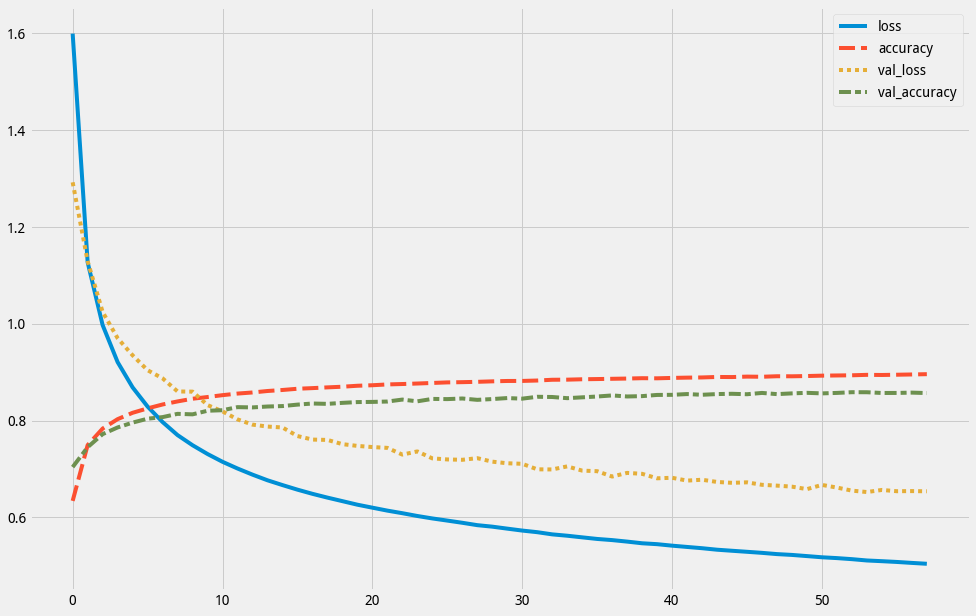

,loss,accuracy,val_loss,val_accuracy
52,0.513600,0.893476,0.655180,0.858530
53,0.510873,0.894402,0.652267,0.858465
54,0.509417,0.894116,0.656569,0.856930
55,0.507819,0.894640,0.653986,0.857018
56,0.505854,0.895181,0.654234,0.857675
57,0.504025,0.895795,0.653793,0.856776


In [28]:
plot_keras_fit_history(results1, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail(6)

In [29]:
image_class_evaluation(model1, X_test, y_test)

Accuracy: 0.7625855553500172
Balanced Accuracy: 0.7633965503141182


(0.7625855553500172, 0.7633965503141182)

### A simple convolutional model.

While the 76% accuracy well outperformed the baseline, there was some room for improvement, so I introduced some convolutional layers. There were initial signs that the learning rate was too high

In [45]:
layers = [Conv2D(32, (3, 3), activation='relu', input_shape=(32 ,32,  1)),
          MaxPooling2D((2, 2)),
          Conv2D(100, (3, 3), activation='relu'),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(40, "relu"),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0002), "metrics":['accuracy']}
model2 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 100)       28900     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 100)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                144040    
_________________________________________________________________
dense_13 (Dense)             (None, 46)               

In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model2-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results2 = model2.fit(X_train_generator, epochs=200, steps_per_epoch=6980, validation_data=(X_val_2d, y_val), callbacks=[backups, stopping])

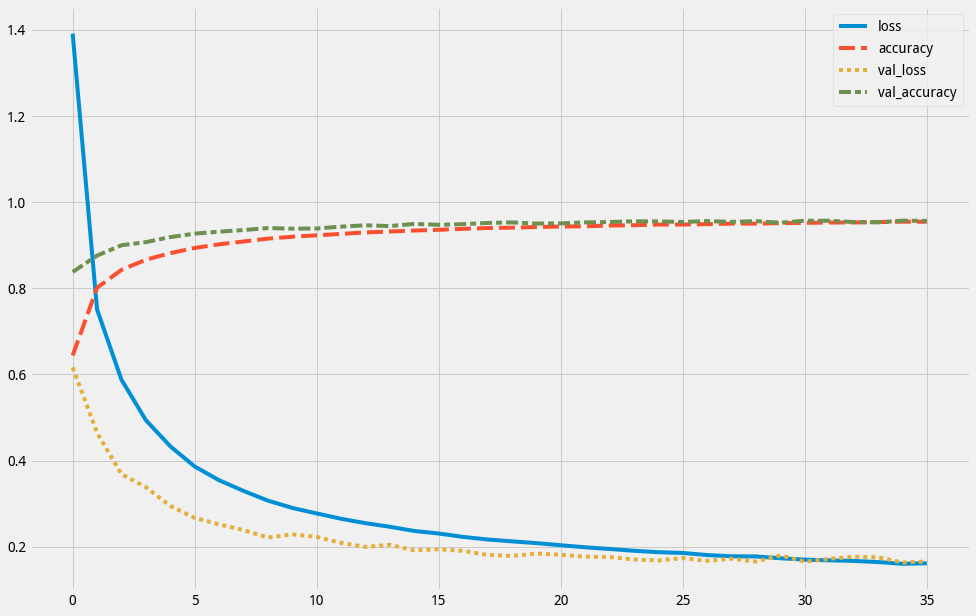

,loss,accuracy,val_loss,val_accuracy
31,0.168216,0.952629,0.171690,0.956629
32,0.166891,0.952772,0.176520,0.953669
33,0.164218,0.953601,0.175208,0.953187
34,0.160203,0.954519,0.163218,0.956871
35,0.161341,0.954443,0.165526,0.956476


In [48]:
plot_keras_fit_history(results2, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [49]:
image_class_evaluation(model2, X_test_2d, y_test)

Accuracy: 0.9174176158135355
Balanced Accuracy: 0.9152941176193541


(0.9174176158135355, 0.9152941176193541)

### Transfer learning from the VGG16 model trained from ImageNet

Next I explored the possibility of transfer learning from models already built with much larger datasets. There seemed to be an absence of pretrained OCR models out there, so the input data required duplication to give the appearence of having three color channels for compatibility with the model.

In [50]:
from tensorflow.keras.applications import VGG16
transfer_layers = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(32, 32, 3))

In [51]:
# Freezes all of the layers below "block3"
transfer_layers.trainable = True
set_trainable = False
for layer in transfer_layers.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [52]:
layers = [transfer_layers,
          Flatten(),
          Dense(40, "relu"),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.000075), "metrics":['accuracy']}
model3 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                20520     
_________________________________________________________________
dense_15 (Dense)             (None, 46)                1886      
Total params: 14,737,094
Trainable params: 14,476,934
Non-trainable params: 260,160
_________________________________________________________________


In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model3-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results3 = model3.fit(X_train_generator_rgb, epochs=200, steps_per_epoch=6980, validation_data=(X_val_rgb, y_val), callbacks=[backups, stopping])

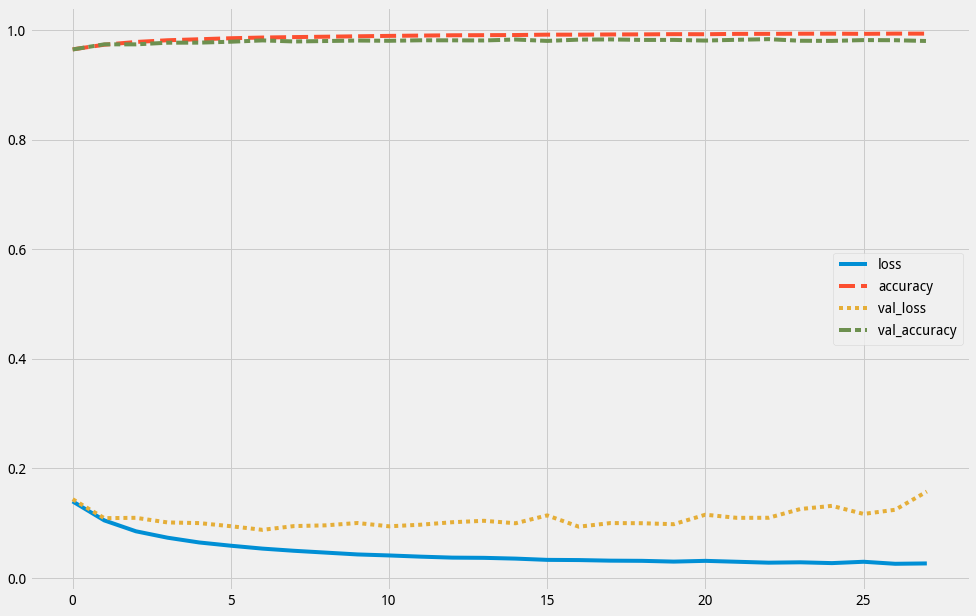

,loss,accuracy,val_loss,val_accuracy
23,0.028563,0.993087,0.125764,0.980244
24,0.027094,0.993190,0.131567,0.979981
25,0.029540,0.992868,0.116843,0.981450
26,0.025852,0.993279,0.124427,0.981209
27,0.026518,0.993194,0.157629,0.979784


In [56]:
plot_keras_fit_history(results3, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [58]:
image_class_evaluation(model3, X_test_rgb, y_test)

Accuracy: 0.9687904653682514
Balanced Accuracy: 0.9681971871435084


(0.9687904653682514, 0.9681971871435084)

While this model gave the best results, it was far more complicated in layers than any of the others and brought in redundant information from duplicating one channel into 3 resulting in by far the most computationally expensive model yet.

### CNN revisited with more convolutional layers

In [68]:
layers = [Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32 ,32,  1)),
          Conv2D(32, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          Conv2D(64, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          Conv2D(128, (3, 3), activation='relu', padding="same"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(40, "relu"),
          Dense(46, activation='softmax')
         ]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.0001), "metrics":['accuracy']}
model4 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 128)       

In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model4-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results4 = model4.fit(X_train_generator, epochs=200, steps_per_epoch=6980, validation_data=(X_val_2d, y_val), callbacks=[backups, stopping])

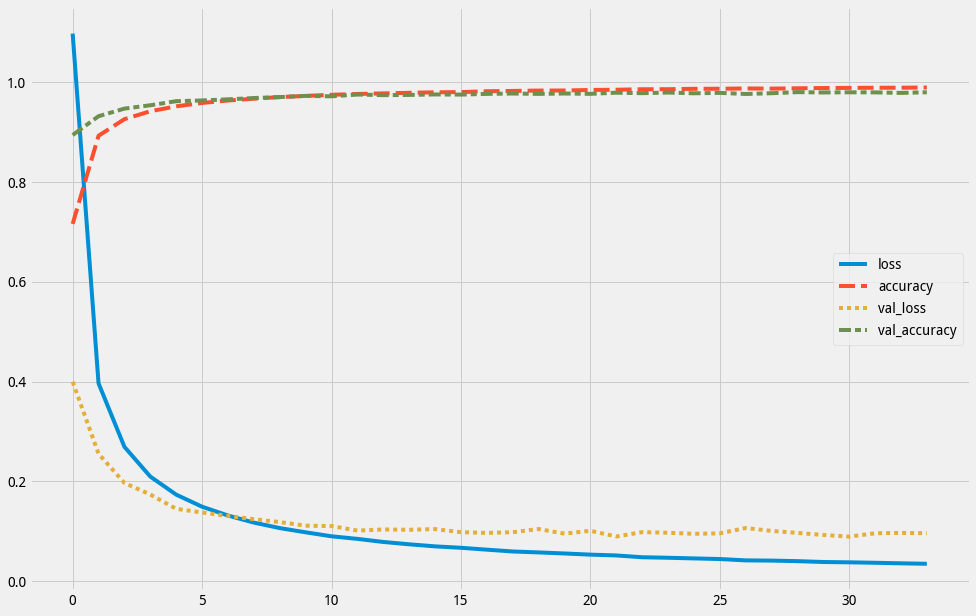

,loss,accuracy,val_loss,val_accuracy
29,0.038758,0.987969,0.092933,0.979082
30,0.038101,0.988296,0.089619,0.979455
31,0.037213,0.988569,0.096285,0.979280
32,0.036122,0.988632,0.097026,0.978205
33,0.035172,0.989111,0.096454,0.979521


In [70]:
plot_keras_fit_history(results4, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [72]:
image_class_evaluation(model4, X_test_2d, y_test)

Accuracy: 0.9586427419994186
Balanced Accuracy: 0.9580981274878225


(0.9586427419994186, 0.9580981274878225)

### Transfer learning from the Kanji Dataset

In [12]:
modelkanji = models.load_model('model_backups/kanji/modelk1-33')

In [16]:
layers = modelkanji.layers[:-2] + [Dense(40, "relu"), Dense(46, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
model5 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [17]:
for layer in model5.layers[0:6]:
    layer.trainable = False

In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model5-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results5 = model5.fit(X_train_generator, epochs=200, steps_per_epoch=6980, validation_data=(X_val_2d, y_val), callbacks=[backups, stopping])

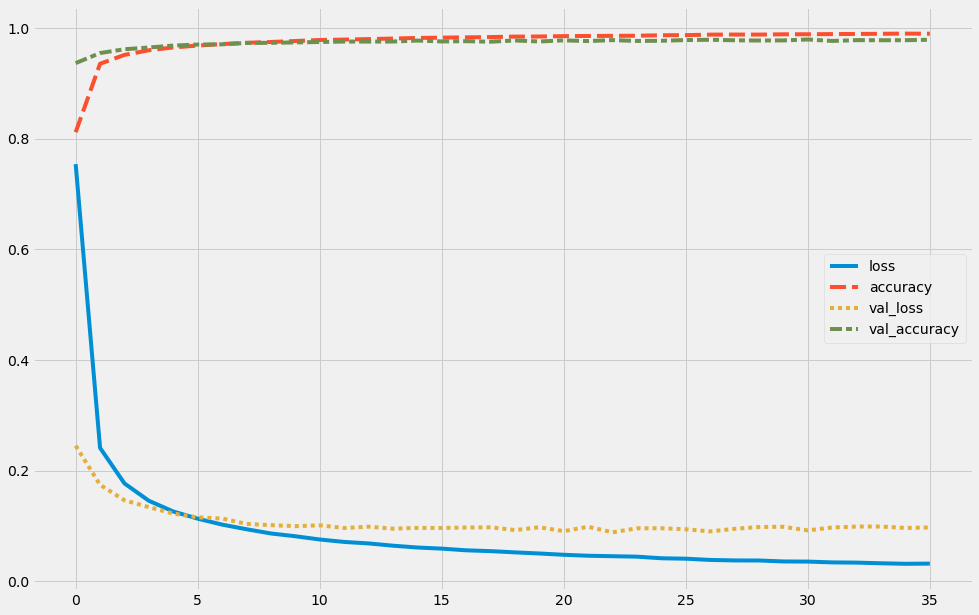

,loss,accuracy,val_loss,val_accuracy
31,0.034467,0.989295,0.097570,0.976889
32,0.034046,0.989527,0.099224,0.978359
33,0.032873,0.989818,0.099223,0.978161
34,0.031939,0.990150,0.096724,0.978227
35,0.032270,0.989939,0.097613,0.979082


In [24]:
plot_keras_fit_history(results5, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [19]:
image_class_evaluation(model5, X_test_2d, y_test)

Accuracy: 0.9621838746333342
Balanced Accuracy: 0.9608097394188841


(0.9621838746333342, 0.9608097394188841)

### Experimental model 5

In [20]:
layers = modelkanji.layers[:-2] + [Dense(40, "relu"), Dense(46, activation='softmax')]
compile_kwargs = {"loss":"categorical_crossentropy", "optimizer":Adam(learning_rate=0.00005), "metrics":['accuracy']}
model6 = generate_keras_model(Sequential(), layers, compile_kwargs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)        

In [21]:
for layer in model6.layers[0:3]:
    layer.trainable = False

In [ ]:
backups = ModelCheckpoint("model_backups/kuzushiji/model6-{epoch:02d}", monitor="val_loss")
stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=5, restore_best_weights=True)

results6 = model6.fit(X_train_generator, epochs=200, steps_per_epoch=6980, validation_data=(X_val_2d, y_val), callbacks=[backups, stopping])

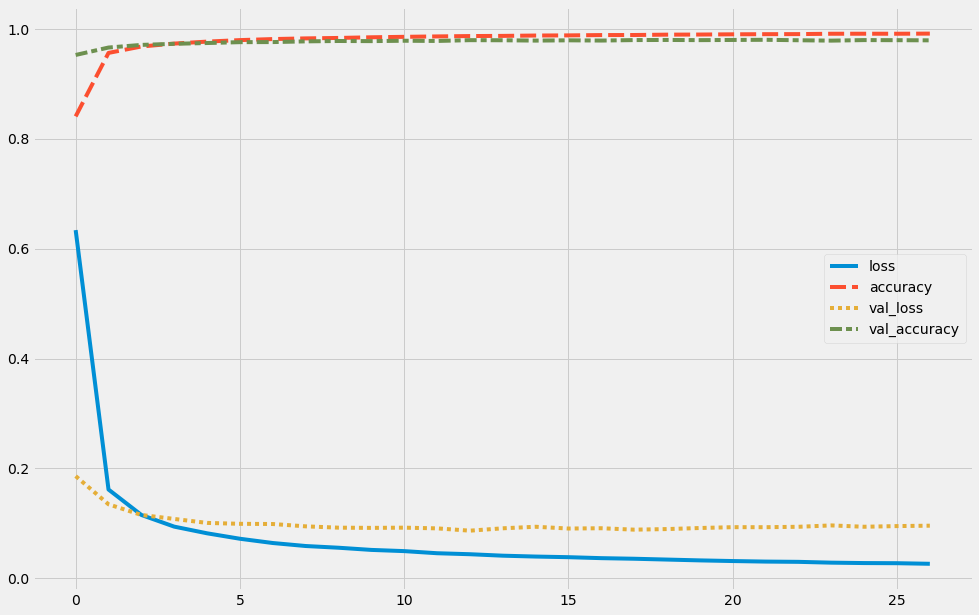

,loss,accuracy,val_loss,val_accuracy
22,0.030021,0.990772,0.093852,0.979586
23,0.028548,0.991412,0.096342,0.978885
24,0.027815,0.991462,0.093905,0.979872
25,0.027558,0.991430,0.095131,0.979696
26,0.026486,0.991668,0.095854,0.979411


In [25]:
plot_keras_fit_history(results6, 0, common_plot_kwargs={"style": "fivethirtyeight"}).tail()

In [23]:
image_class_evaluation(model6, X_test_2d, y_test)

Accuracy: 0.9629502391585846
Balanced Accuracy: 0.9618871587756146


(0.9629502391585846, 0.9618871587756146)

## Evaluation

### Where the model fell short

To help get better context behind the model's accuracy and potential room for growth, at this point it would help to take a closer look at where it went wrong.

In [167]:
raw_predictions = model3.predict(X_test_2d)
prediction_labels = np.argmax(raw_predictions, axis=1)
probabilities = pd.DataFrame(raw_predictions[error_selection], columns = classmap["char"].values)

In [383]:
#This creates a mask that will allow easy selection among the cases where the model resulted in a misclassification.
error_selection = (prediction_labels != test_labels)

In [177]:
bulk_character_viewer(data=test_data[error_selection],
                      labels=map_char_codes(test_labels[error_selection], classmap),
                      predictions=map_char_codes(prediction_labels[error_selection], classmap),
                      indices=(0,50), columns=10)

One common occurrence in the misclassified predictions involves the now obsolete iteration mark for character repetition (ゝ). While in a few cases it clearly misses the mark, there are several instances where it is understandably confused with the character ku (く). Because in the dataset of the kuzushiji writing style it often appears inverted in along the vertical axis, it would be quite a difficult task for a human to discern the differences between the two under these conditions.

In [155]:
bulk_character_viewer(data=train_data[train_labels==48],
                      labels=map_char_codes(train_labels[train_labels==48], classmap),
                      indices=(0,36), columns=12)

In [379]:
bulk_character_viewer(data=train_data[train_labels==7],
                      labels=map_char_codes(train_labels[train_labels==7], classmap),
                      indices=(0,36), columns=12)

Other outright misses due to the apparent contradictions in the data can be seen in the above images at 5, 9, and 40. Others were close calls. For example in the case of image 22 where there was a prediction that had mistaken so(そ) for u(う), the model was nearly equally divided in it's decision between the two.

In [191]:
probabilities.iloc[22].sort_values(ascending=False).head(4)

う    0.516809
そ    0.471877
か    0.007497
り    0.000700
Name: 22, dtype: float32

## Hidden layers

To help understand this prediction, I turned to the hidden layers in the convolutional layers.

In [270]:
#The because this was a transfer learning model, the cnn layers from the imported model are all located within the first layer.
cnn_outputs = [layer.output for layer in model3.layers[0].layers[:20]]
dense_outputs = [layer.output for layer in model3.layers[1:4]]

#I've created seperate models to track the outputs in the cnn and dense layers
all_activations = models.Model(inputs=[model3.layers[0].input, model3.input], outputs=[*cnn_outputs, *dense_outputs])
cnn_activations = models.Model(inputs=model3.layers[0].input, outputs=cnn_outputs)
intermediate_predictor = models.Model(inputs=model3.layers[0].input, outputs=[cnn_outputs[-1]])
#dense_activations = models.Model(inputs=Input([1, 1, 512]), outputs=dense_outputs)

In [252]:
so_mistaken = np.expand_dims(X_test_2d[error_selection][22], axis=0)

In [271]:
cnn_layers = cnn_activations.predict(so_mistaken)
so_intermediate = intermediate_predictor.predict(so_mistaken)
#dense_layers = cnn_activations.predict(so_intermediate)

In [294]:
second_layer_activation = cnn_layers[1]
print(second_layer_activation.shape)

(1, 32, 32, 64)


In the early early layers (that were frozen during training) it's seperating out various low level features of the character but there appears to be more than a few channels that closely resemble others.

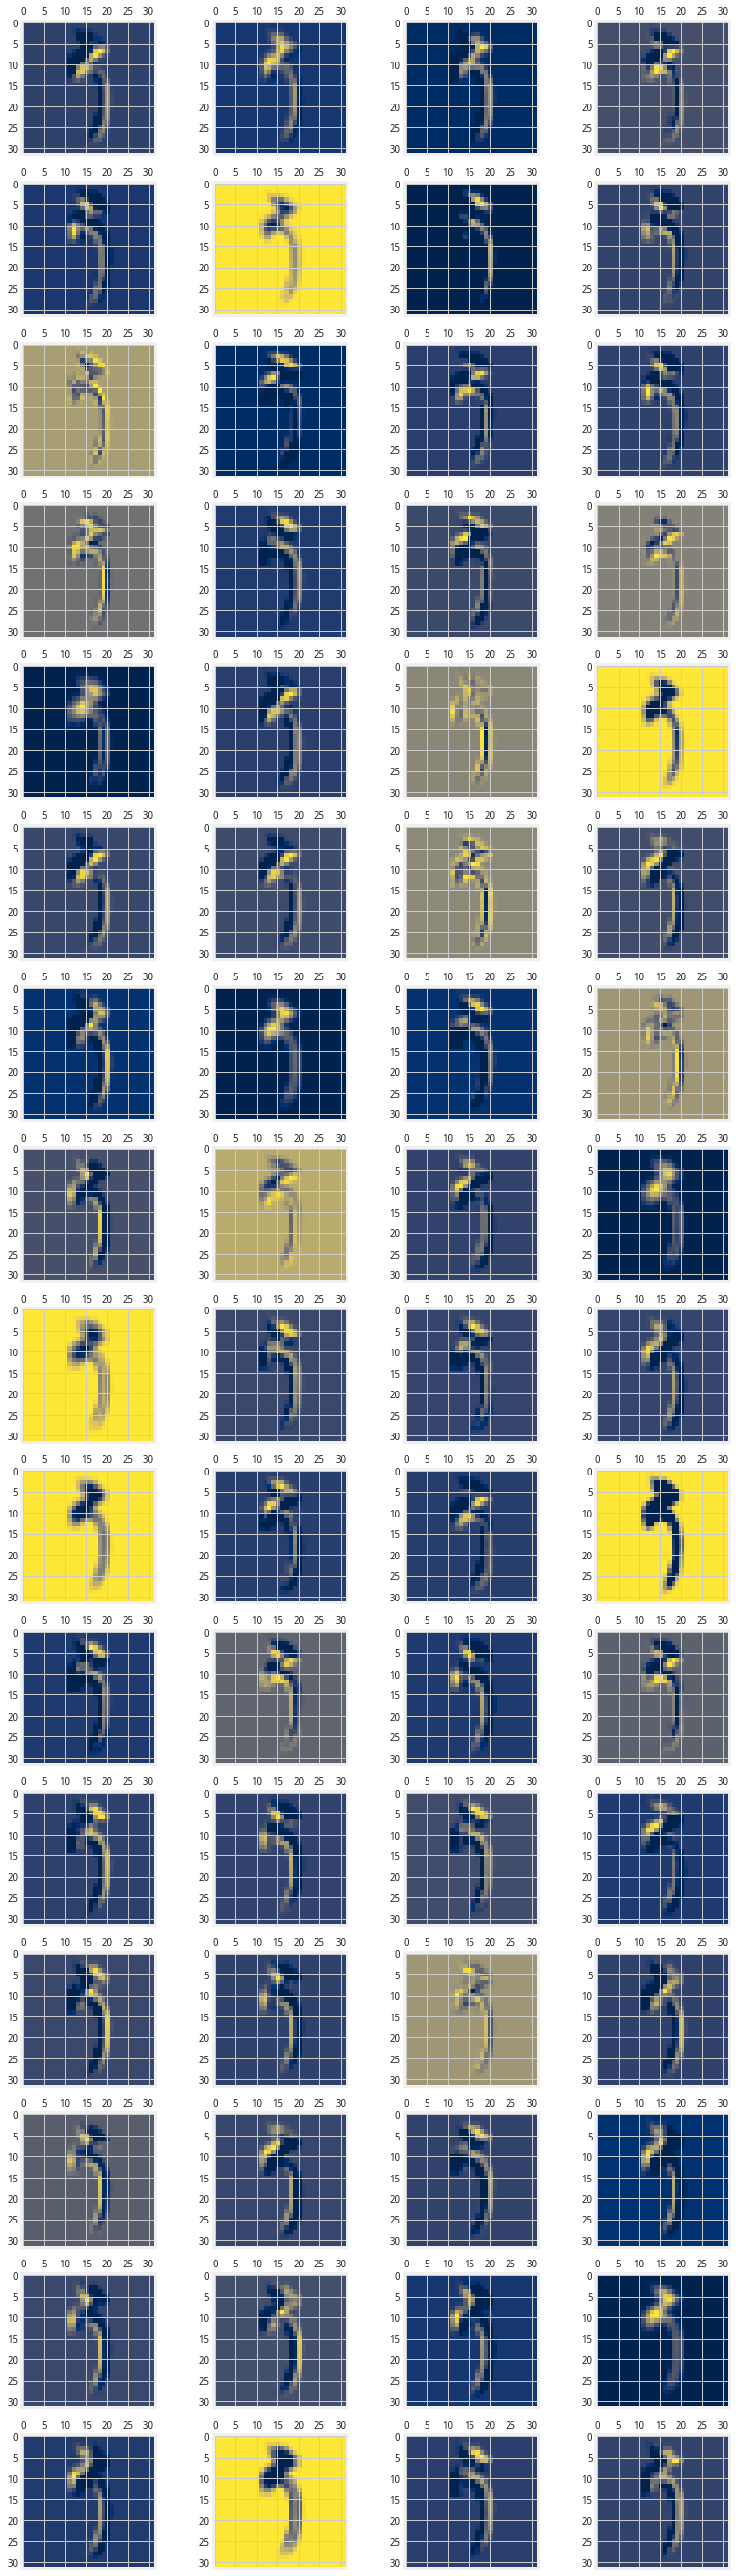

In [375]:
fig, axes = plt.subplots(16, 4, figsize=(12,48))
for i in range(64):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(second_layer_activation[0, :, :, i], cmap='cividis')

Farther down the line the features become more abstract. The ones below had their weights adjusted with the new training.

In [343]:
fourth_layer_activation = cnn_layers[3]
print(fourth_layer_activation.shape)

(1, 16, 16, 64)


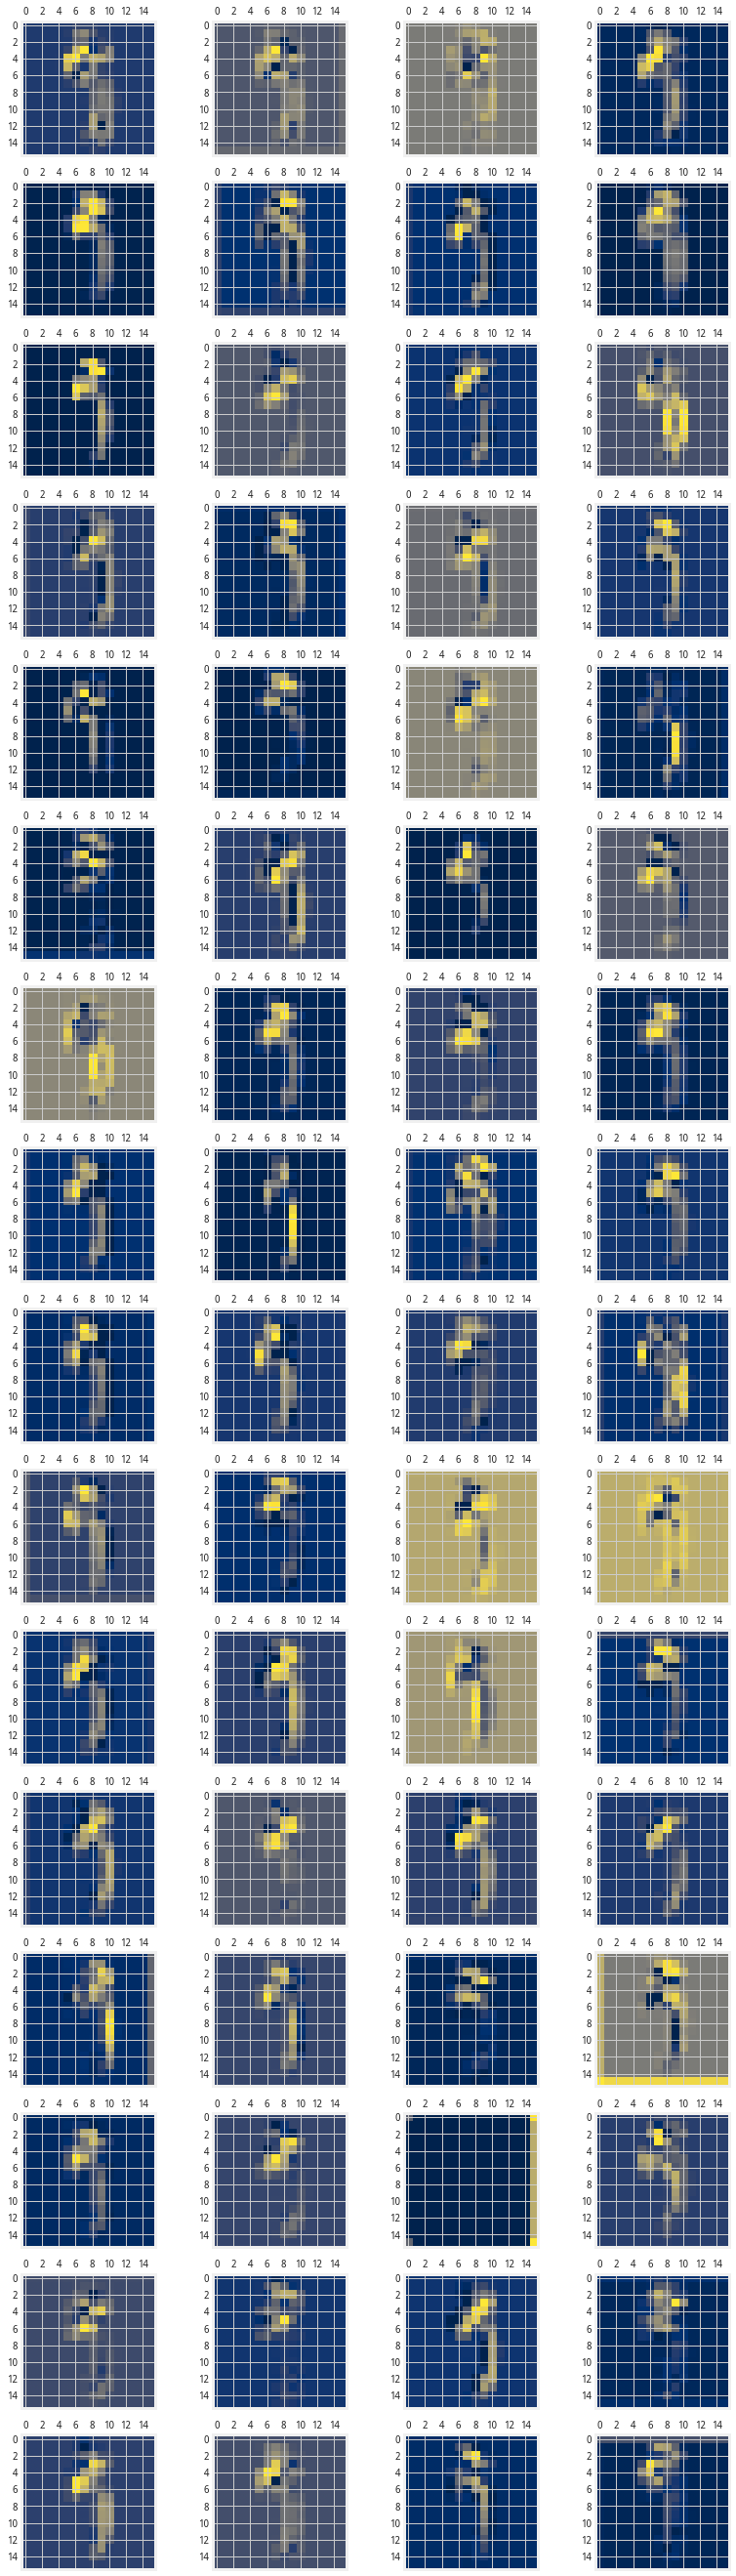

In [376]:
fig, axes = plt.subplots(16, 4, figsize=(12,48))
for i in range(64):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(fourth_layer_activation[0, :, :, i], cmap='cividis')

In [359]:
tenth_layer_activation = cnn_layers[10]
print(tenth_layer_activation.shape)

(1, 4, 4, 256)


As this model gets farther down the convolution line, it's resolution becomes reduced while the number of channels increases greatly. In this particular layer for this model, it appears that the vast majority of channels were underutilized.

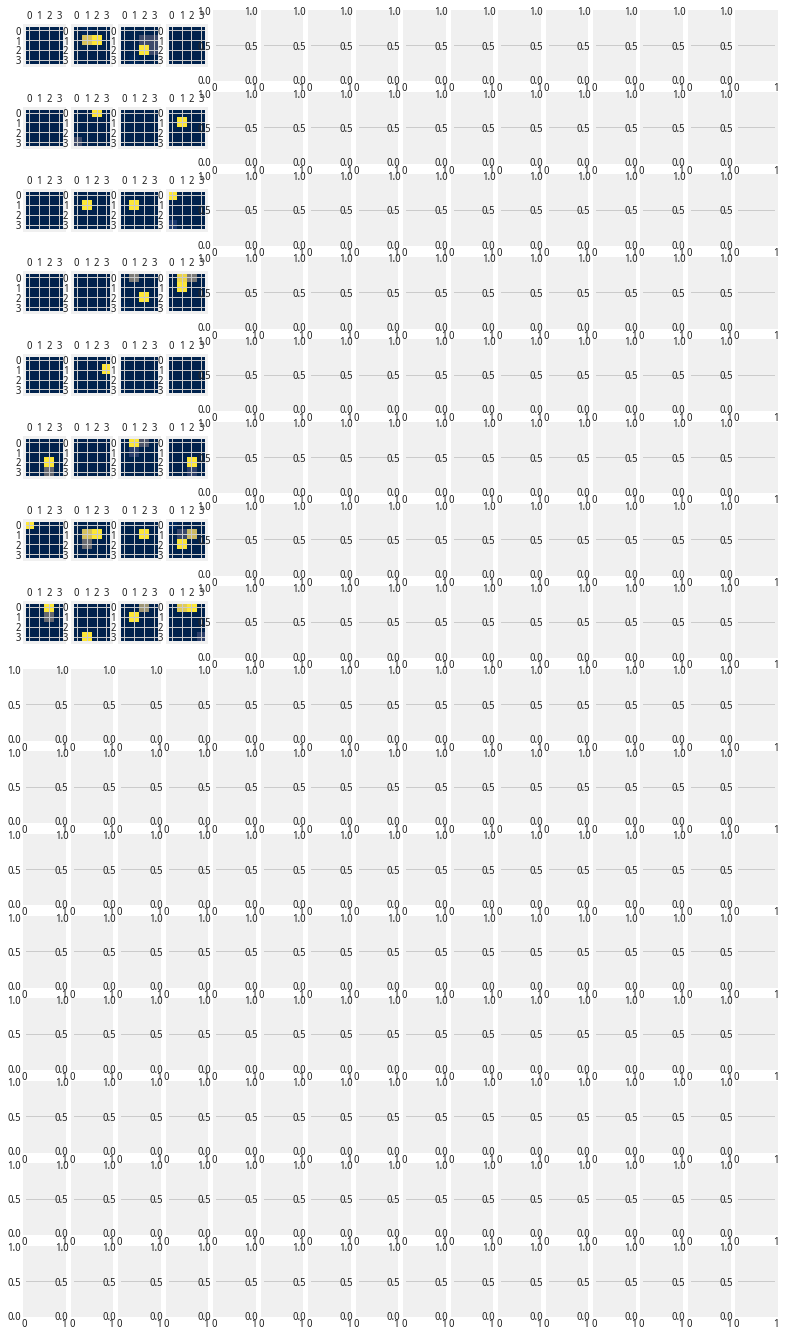

In [377]:
fig, axes = plt.subplots(16, 16, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    ax.matshow(tenth_layer_activation[0, :, :, i], cmap='cividis')

Perhaps this particular model is overly complex and would benefit from a reduction of cnn layers. The next logical step would be to see if there is a happy medium between the 2nd and third models. Possibly avoiding transfer learning from those libraries all together and instead leaveraging the full kuzushiji dataset with Kanji to build the inital hidden layers and eliminate the need for redunency in the other channels.